In [1]:
import numpy as np
import os

In [2]:
from vtxmpasmeshes.mesh_generator import variable_resolution_latlonmap

# define grid type and the desired mesh info
grid = 'doughnut'
test = {'highresolution': 3, 'lowresolution': 20, 'size': 30,
        'margin': 80, 'lat_ref': 40., 'lon_ref': 0.}
print(test)

# we generate an Xarray Dataset containing, for each lat, lon point,
# the distance to a reference point and the corresponding resolution
# given the mesh info
ds = variable_resolution_latlonmap(grid, **test)
print(ds)

{'highresolution': 3, 'lowresolution': 20, 'size': 30, 'margin': 80, 'lat_ref': 40.0, 'lon_ref': 0.0}

>> Creating a variable resolution map
	Resolution in km of lat/lon grid: 3.0
	Computing the distance to the reference point (40.00, 0.00)
	Computing resolutions using technique doughnut
<xarray.Dataset>
Dimensions:     (lat: 6601, lon: 13201)
Coordinates:
  * lat         (lat) float64 -90.0 -89.97 -89.95 -89.92 ... 89.95 89.97 90.0
  * lon         (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
Data variables:
    distance    (lat, lon) float64 1.445e+04 1.445e+04 ... 5.556e+03 5.556e+03
    resolution  (lat, lon) float64 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
Attributes:
    highresolution:  1
    lowresolution:   25
    size:            40
    margin:          100
    final_res_dist:  1000
    lat_ref:         0.0
    lon_ref:         0.0
    radius:          140
    buffer:          250
    border:          390


In [3]:
from vtxmpasmeshes.mesh_generator import get_mesh_from_resolution

# temporary folder
tmp_dir = 'tmp'
os.system(f'mkdir {tmp_dir}')

# we generate an spherical grid using a simplification of a Jigsaw script
# and we save it as a NetCDF file in the temporary folder 
global_grid, graph_info = get_mesh_from_resolution(resolution_ds=ds,
                                                   basename=f'{tmp_dir}/mesh')


>> Generating an MPAS mesh

	 .- Jigsaw generation
 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation library.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.14

  Reading CFG. file...

  CFG. data summary...

  GEOM-FILE = tmp/mesh.msh 
  MESH-FILE = tmp/mesh-MESH.msh 
  HFUN-FILE = tmp/mesh-HFUN.msh 
  INIT-FILE =  
  TRIA-FILE =  
  BNDS-FILE =  

  GEOM-SEED = 8 
  GEOM-PHI1 = 6.00e+01 
  GEOM-PHI2 = 6.00e+01 
  GEOM-ETA1 = 4.50e+01 
  GEOM-ETA2 = 4.50e+01 
  GEOM-FEA

Write graph.info file


In [4]:
from vtxmpasmeshes.mesh_generator import cut_circular_region

# we cut the global mesh given the radius (in meters) and the center point
regional_grid, grid_info = cut_circular_region(mpas_global_file=global_grid,
                                               region_radius_meters=ds.attrs['radius'] * 1000,
                                               lat_cen=ds.attrs['lat_ref'],
                                               lon_cen=ds.attrs['lon_ref'])
os.system('rm -rf tmp points.txt')
os.system('mkdir grids')
os.system('mv circle* global* grids')

KeyError: 'lat_ref'

(-3.115352496116939, 3.1004873213301796, 37.52271099312958, 42.57044562166073)


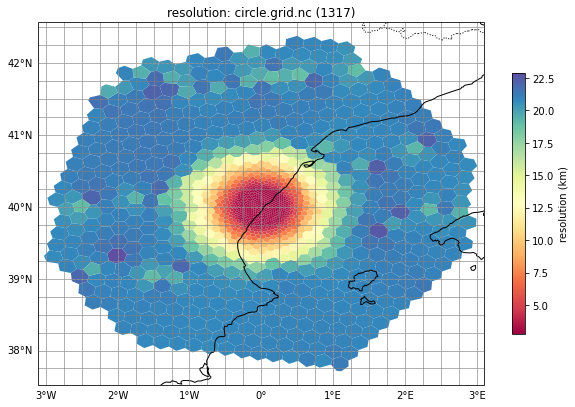

<xarray.Dataset>
Dimensions:               (nCells: 1317, nEdges: 4039, nVertices: 2723, maxEdges: 8, maxEdges2: 16, TWO: 2, vertexDegree: 3)
Dimensions without coordinates: nCells, nEdges, nVertices, maxEdges, maxEdges2, TWO, vertexDegree
Data variables: (12/51)
    bdyMaskCell           (nCells) int32 ...
    bdyMaskEdge           (nEdges) int32 ...
    bdyMaskVertex         (nVertices) int32 ...
    latCell               (nCells) float64 0.7229 0.7253 ... 0.7003 0.7001
    lonCell               (nCells) float64 0.03697 0.03447 ... 0.005522 6.278
    xCell                 (nCells) float64 ...
    ...                    ...
    latitude              (nCells) float64 41.42 41.56 41.39 ... 40.12 40.11
    longitude             (nCells) float64 2.118 1.975 1.882 ... 0.3164 -0.314
    latitudeVertex        (nVertices) float64 39.49 40.01 39.98 ... 40.13 40.12
    longitudeVertex       (nVertices) float64 -0.01473 0.3673 ... -0.3396
    area                  (nCells) float64 349.8 347.0 346.2 ... 7.76 9.277
    resolution            (nCells) float64 21.1 21.02 20.99 ... 3.143 3.437
Attributes:
    on_a_sphere:    YES
    sphere_radius:  1.0

In [5]:
from vtxmpasmeshes.mpas_plots import view_mpas_regional_mesh

# we can plot the regional MPAS mesh with a reanalysis grid.
# do_plot_resolution_rings and do_plot_wrf_grid must be set to False
view_mpas_regional_mesh(mpas_grid_file=f'grids/circle.grid.nc',
                        do_plot_resolution_rings=False,
                        do_plot_era5_grid=True,
                        do_plot_wrf_grid=False)

In [6]:
#################################################################################################################

import xarray as xr

# Open dataset and update attributes
regional_ds = xr.open_dataset(f'grids/{regional_grid}')
num_boundary_layers = 8

for name, value in ds.attrs.items():
    regional_ds.attrs['vtx-param-' + str(name)] = value
print(regional_ds)
regional_ds.attrs['vtx-region-num_boundary_layers'] = num_boundary_layers
lowres = ds.attrs['lowresolution']
radius = ds.attrs['radius']
region_border = radius + (num_boundary_layers * lowres) * 0.6
regional_ds.attrs['vtx-region_border'] = region_border

regional_ds.to_netcdf(f'grids/{regional_grid}')

regional_ds

<xarray.Dataset>
Dimensions:               (nCells: 1317, nEdges: 4039, nVertices: 2723, maxEdges: 8, maxEdges2: 16, TWO: 2, vertexDegree: 3)
Dimensions without coordinates: nCells, nEdges, nVertices, maxEdges, maxEdges2, TWO, vertexDegree
Data variables: (12/45)
    bdyMaskCell           (nCells) int32 ...
    bdyMaskEdge           (nEdges) int32 ...
    bdyMaskVertex         (nVertices) int32 ...
    latCell               (nCells) float64 ...
    lonCell               (nCells) float64 ...
    xCell                 (nCells) float64 ...
    ...                    ...
    cellQuality           (nCells) float64 ...
    gridSpacing           (nCells) float64 ...
    triangleQuality       (nVertices) float64 ...
    triangleAngleQuality  (nVertices) float64 ...
    obtuseTriangle        (nVertices) int32 ...
    meshDensity           (nCells) float64 ...
Attributes:
    on_a_sphere:               YES
    sphere_radius:             1.0
    vtx-param-highresolution:  3
    vtx-param-lowresol

<xarray.Dataset>
Dimensions:               (nCells: 1317, nEdges: 4039, nVertices: 2723, maxEdges: 8, maxEdges2: 16, TWO: 2, vertexDegree: 3)
Dimensions without coordinates: nCells, nEdges, nVertices, maxEdges, maxEdges2, TWO, vertexDegree
Data variables: (12/45)
    bdyMaskCell           (nCells) int32 ...
    bdyMaskEdge           (nEdges) int32 ...
    bdyMaskVertex         (nVertices) int32 ...
    latCell               (nCells) float64 ...
    lonCell               (nCells) float64 ...
    xCell                 (nCells) float64 ...
    ...                    ...
    cellQuality           (nCells) float64 ...
    gridSpacing           (nCells) float64 ...
    triangleQuality       (nVertices) float64 ...
    triangleAngleQuality  (nVertices) float64 ...
    obtuseTriangle        (nVertices) int32 ...
    meshDensity           (nCells) float64 ...
Attributes: (12/14)
    on_a_sphere:                     YES
    sphere_radius:                   1.0
    vtx-param-highresolution:        3
    vtx-param-lowresolution:         20
    vtx-param-size:                  30
    vtx-param-margin:                80
    ...                              ...
    vtx-param-final_res_dist:        1000
    vtx-param-radius:                110
    vtx-param-buffer:                200
    vtx-param-border:                310
    vtx-region-num_boundary_layers:  8
    vtx-region_border:               206.0

(nan, nan, nan, nan)


ValueError: Failed to determine the required bounds in projection coordinates. Check that the values provided are within the valid range (x_limits=[-180.0, 180.0], y_limits=[-90.0, 90.0]).

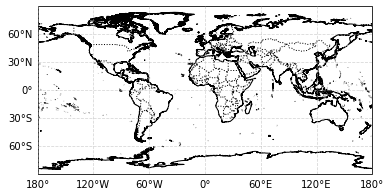

In [9]:
ds = view_mpas_regional_mesh(mpas_grid_file=f'grids/{regional_grid}',
                             do_plot_resolution_rings=False,
                             do_plot_era5_grid=True,
                             do_plot_wrf_grid=False)